from pprint import pprint
import functools

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pytorch_lightning as pl
from transformers import AutoModelForSequenceClassification, CamembertForMaskedLM, AutoTokenizer, AutoConfig
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm.notebook import tqdm

In [19]:
import torch
from torch.utils.data import DataLoader, Dataset

from transformers import AutoModelForSequenceClassification, CamembertForMaskedLM, AutoTokenizer, AutoConfig,CamembertConfig
from tqdm.notebook import tqdm
import functools

from sklearn.metrics import confusion_matrix, f1_score
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
config = CamembertConfig.from_json_file('config.json')
CamemBert = CamembertForMaskedLM.from_pretrained('pytorch_model.bin',config=config)


c:\Users\mthia\anaconda3\envs\NLP_3A\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at pytorch_model.bin were not used when initializing CamembertForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing CamembertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassificat

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [3]:
train_data = pd.read_csv('questions_train.csv')
test_data = pd.read_csv('questions_test.csv')

train_data.head()

,id,category,subcategory,question,extra_description,article_ids
0,1102,Travail,Travail et parentalité,Je suis travailleur salarié(e). Puis-je refuse...,Pendant la grossesse,"22225,22226,22227,22228,22229,22230,22231,2223..."
1,91,Argent,Dettes,Peut-on saisir tous mes revenus ?,"Procédures de récupération des dettes, Récupér...","5853,5854,5855"
2,474,Famille,Situation de couples,Je suis marié(e). Nous sommes mariés. Dois-je ...,Mariage,"1096,1097,1098,1108,1109,1110"
3,836,Logement,Location en Wallonie,Je mets un kot en location (bail de droit comm...,"Mettre un logement en location (Wallonie), Doi...","12012,12030,12031,12032,12033,12034,12035"
4,1079,Travail,Maladie - incapacité de travail,Suis-je payé pendant la procédure du trajet de...,Rupture du contrat de travail pour force majeu...,"21114,21115,21116,21117,21118,21119,21120,2112..."


In [4]:
train_data = train_data[['category', 'question']]

test_data = test_data[['category', 'question']]

In [5]:
train_data.head()

,category,question
0,Travail,Je suis travailleur salarié(e). Puis-je refuse...
1,Argent,Peut-on saisir tous mes revenus ?
2,Famille,Je suis marié(e). Nous sommes mariés. Dois-je ...
3,Logement,Je mets un kot en location (bail de droit comm...
4,Travail,Suis-je payé pendant la procédure du trajet de...


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886 entries, 0 to 885
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  886 non-null    object
 1   question  886 non-null    object
dtypes: object(2)
memory usage: 14.0+ KB


C:\Users\mthia\AppData\Local\Temp\ipykernel_3804\209884929.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, x='category', palette='viridis', width=0.4)
c:\Users\mthia\anaconda3\envs\NLP_3A\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\mthia\anaconda3\envs\NLP_3A\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\mthia\anaconda3\envs\NLP

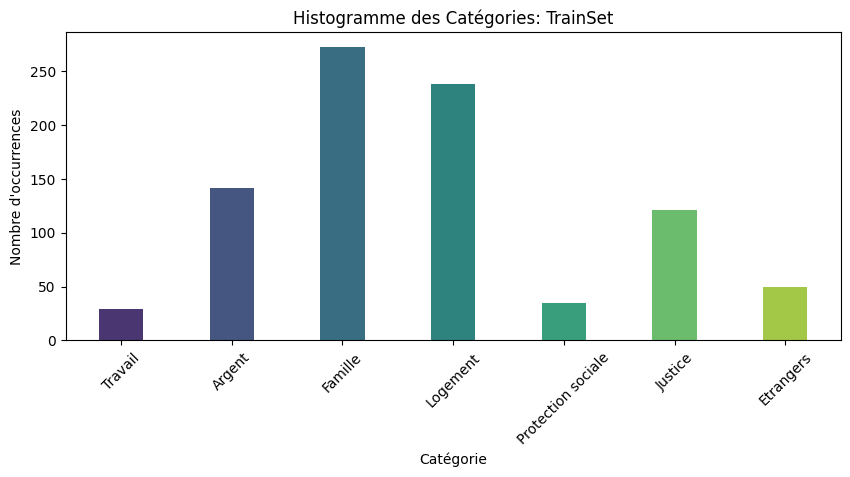

In [7]:
# Afficher le nombre d'occurrences de chaque catégorie dans le jeu de données d'entrainement
plt.figure(figsize=(10, 4))
sns.countplot(data=train_data, x='category', palette='viridis', width=0.4)
plt.title('Histogramme des Catégories: TrainSet')
plt.xlabel('Catégorie')
plt.ylabel('Nombre d\'occurrences')
plt.xticks(rotation=45)
plt.show()


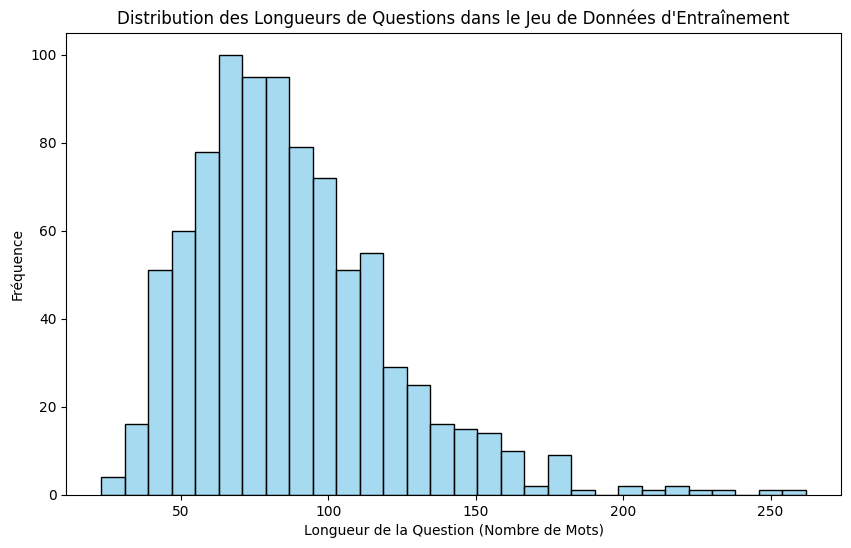

In [13]:

train_data['question_length'] = train_data['question'].apply(lambda x: len(x))

plt.figure(figsize=(10, 6))
sns.histplot(data=train_data, x='question_length', bins=30, color='skyblue', edgecolor='black', kde=False)
plt.title('Distribution des Longueurs de Questions dans le Jeu de Données d\'Entraînement')
plt.xlabel('Longueur de la Question (Nombre de Mots)')
plt.ylabel('Fréquence')
plt.show()

 


In [10]:
# Notamment, aucune phrase ne comporte plus de 512 caractères, et donc aucune phrase ne comportera plus de 512 tokens:
print(train_data["question_length"].any()>512)

False


In [8]:
tokenizer = AutoTokenizer.from_pretrained('camembert-base')


In [10]:
# obliger de changer comme ça les données pour pouvoir utiliser DataLoader de torch avec csv file
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

train_dataset = CustomDataset('questions_train.csv')
test_dataset = CustomDataset('questions_test.csv')

# Display the head of the dataset
print(train_dataset.data.head())

     id  category                      subcategory  \
0  1102   Travail           Travail et parentalité   
1    91    Argent                           Dettes   
2   474   Famille             Situation de couples   
3   836  Logement             Location en Wallonie   
4  1079   Travail  Maladie - incapacité de travail   

                                            question  \
0  Je suis travailleur salarié(e). Puis-je refuse...   
1                  Peut-on saisir tous mes revenus ?   
2  Je suis marié(e). Nous sommes mariés. Dois-je ...   
3  Je mets un kot en location (bail de droit comm...   
4  Suis-je payé pendant la procédure du trajet de...   

                                   extra_description  \
0                               Pendant la grossesse   
1  Procédures de récupération des dettes, Récupér...   
2                                            Mariage   
3  Mettre un logement en location (Wallonie), Doi...   
4  Rupture du contrat de travail pour force majeu...   

 

In [11]:
# Définir la correspondance des catégories avec des valeurs numériques
category_mapping = {'Travail': 0, 'Argent': 1, 'Famille': 2, 'Logement': 3, 'Protection sociale': 4, 'Justice': 5, 'Etrangers': 6}

# Appliquer la correspondance au DataFrame
train_dataset.data['labels'] = train_dataset.data['category'].map(category_mapping)
test_dataset.data['labels'] = test_dataset.data['category'].map(category_mapping)

# Vérifier les valeurs uniques dans la nouvelle colonne
unique_categories_numeric = train_dataset.data['labels'].unique()
print("Nombre de classes :", unique_categories_numeric)




Nombre de classes : [0 1 2 3 4 5 6]


In [12]:
num_category= train_dataset.data["labels"].nunique()
print("Nombre de classes :", num_category)


Nombre de classes : 7


In [16]:
# Utilisons maintenant CamemBERT afin d’obtenir une représentation vectorielle de chacun des messages!
def tokernize_batch(samples, tokenizer):
    text = [sample["question"] for sample in samples]
    category = [sample['category'] for sample in samples]
    labels = torch.tensor([sample["labels"] for sample in samples])


    tokens = tokenizer(text, padding='longest', return_tensors='pt')
    return {"input_ids": tokens.input_ids, "attention_mask": tokens.attention_mask,"labels": labels, "category": category, "sentences": text}


In [17]:
train_DataLoader = DataLoader(train_dataset, 
                              collate_fn=functools.partial(tokernize_batch, tokenizer = tokenizer), 
                              batch_size=16,
                              shuffle=True)
batch = next(iter(train_DataLoader))  
batch
# les input du model Camembert

{'input_ids': tensor([[    5,   877,   264,    26,   662,  3528,    13,  2196, 26826,    15,
           3273,   106,     6,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1],
         [    5,   407,  2669,     8,   125,   155,  5041,     8,  1531,    14,
             18,    11,  4072,    30,    26,   144, 11224,    35,    15,  3273,
            106,     6,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1],
         [    5,   799,    85,    86,    16,  2221,  6982,    35,    25,   347,
              8,  1052,    22, 16755,   106,     6,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1

In [57]:
print("\n".join(tokenizer.batch_decode(batch["input_ids"])))

<s> Je dépose plainte auprès d'un médiateur. L'entreprise est située en Belgique. Dans combien de temps le médiateur pour le consommateur me répondra?</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
<s> Quelle est la différence entre le forfait et la provision pour charges à Bruxelles?</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
<s> Comment se déroule la saisie immobilière?</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
<s> Dégâts dans le logement : qui paie quoi à Bruxelles?</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
<s> Suis-je obligé de me présenter à l’audience devant le tribunal de police?</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [18]:
test_DataLoader = DataLoader(test_dataset, 
                              collate_fn=functools.partial(tokernize_batch, tokenizer = tokenizer), 
                              batch_size=16,
                              shuffle=False)

### Preparation du modèle avec Pytorch Lightning 

In [20]:
class LightningModel(pl.LightningModule):
    def __init__(self, model_name, num_labels, lr, weight_decay, from_scratch=False):
        super().__init__()
        self.save_hyperparameters()
        if from_scratch:
            # Si `from_scratch` est vrai, on charge uniquement la config (nombre de couches, hidden size, etc.) et pas les poids du modèle 
            config = AutoConfig.from_pretrained(
                model_name, num_labels=num_labels
            )
            self.model = AutoModelForSequenceClassification.from_config(config)
        else:
            # Cette méthode permet de télécharger le bon modèle pré-entraîné directement depuis le Hub de HuggingFace sur lequel sont stockés de nombreux modèles
            self.model = AutoModelForSequenceClassification.from_pretrained(
                model_name, num_labels=num_labels
            )
        self.lr = lr
        self.weight_decay = weight_decay
        self.num_labels = self.model.num_labels

    def forward(self, batch):
        return self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )

    def training_step(self, batch):
        out = self.forward(batch)

        logits = out.logits
        # -------- MASKED --------
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(logits.view(-1, self.num_labels), batch["labels"].view(-1))

        # ------ END MASKED ------

        self.log("train/loss", loss)

        return loss

    def validation_step(self, batch, batch_index):
        labels= batch["labels"]
        out = self.forward(batch)

        preds = torch.max(out.logits, -1).indices
        # -------- MASKED --------
        acc = (batch["labels"] == preds).float().mean()
        # ------ END MASKED ------
        self.log("valid/acc", acc)

        f1 = f1_score(batch["labels"].cpu().tolist(), preds.cpu().tolist(), average="macro")
        self.log("valid/f1", f1)

    def predict_step(self, batch, batch_idx):
        """La fonction predict step facilite la prédiction de données. Elle est 
        similaire à `validation_step`, sans le calcul des métriques.
        """
        out = self.forward(batch)

        return torch.max(out.logits, -1).indices

    def configure_optimizers(self):
        return torch.optim.AdamW(
            self.model.parameters(), 
            lr=self.lr, 
            weight_decay=self.weight_decay
        )

In [21]:
lightning_model = LightningModel("camembert-base", num_category, lr=3e-5, weight_decay=0.)


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor="valid/acc", mode="max")

camembert_trainer = pl.Trainer(
    max_epochs=20,
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs/"),

    callbacks=[
        pl.callbacks.EarlyStopping(monitor="valid/acc", patience=4, mode="max"),
        model_checkpoint,
    ]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [25]:
camembert_trainer.fit(lightning_model, train_dataloaders=train_DataLoader, val_dataloaders=test_DataLoader)


You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                               | Params
-------------------------------------------------------------
0 | model | CamembertForSequenceClassification | 110 M 
-------------------------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
442.509   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\mthia\anaconda3\envs\NLP_3A\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\mthia\anaconda3\envs\NLP_3A\Lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\mthia\anaconda3\envs\NLP_3A\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\mthia\anaconda3\envs\NLP_3A\Lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 14. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [26]:
camembert_trainer.validate(lightning_model, test_DataLoader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\mthia\anaconda3\envs\NLP_3A\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         valid/acc         │     0.954954981803894     │
│         valid/f1          │     0.905487060546875     │
└───────────────────────────┴───────────────────────────┘

[{'valid/acc': 0.954954981803894, 'valid/f1': 0.905487060546875}]

### Inférence avec le modèle entraîné


In [27]:
# Créer le mapping inverse des catégories numériques vers les étiquettes d'origine
ID_TO_LABEL = {v: k for k, v in category_mapping.items()}

# Vérifier le mapping ID_TO_LABEL
print("ID_TO_LABEL :", ID_TO_LABEL)

ID_TO_LABEL : {0: 'Travail', 1: 'Argent', 2: 'Famille', 3: 'Logement', 4: 'Protection sociale', 5: 'Justice', 6: 'Etrangers'}


In [29]:
def get_preds(model, tokenizer, sentence):
    # Tokeniser la phrase en utilisant le tokenizer
    tokenized_sentence = tokenizer(sentence, return_tensors="pt")
    input_ids, attention_mask = tokenized_sentence.input_ids, tokenized_sentence.attention_mask

    # Obtenir les prédictions du modèle pour la phrase
    out = model(
        input_ids=tokenized_sentence.input_ids,
        attention_mask=tokenized_sentence.attention_mask
    )

    # Extraire les logits du modèle
    logits = out.logits

    # Appliquer la fonction softmax pour obtenir les probabilités
    probas = torch.softmax(logits, -1).squeeze()

    # Trouver la classe prédite en sélectionnant l'indice avec la probabilité maximale
    pred = torch.argmax(probas)

    # Utiliser le mapping ID_TO_LABEL pour obtenir l'étiquette correspondante à la classe prédite
    pred_label = ID_TO_LABEL[pred.item()]

    # Retourner l'étiquette prédite et la probabilité associée
    return pred_label, probas[pred].item()


In [30]:
phrases = [
    "Quels sont mes droits au travail?",
    "Comment gérer mes finances efficacement?",
    "Comment renforcer les liens familiaux?",
    "Quelles sont les options de logement disponibles?",
    "Comment obtenir une protection sociale adéquate?",
    "Quels sont les recours en cas d'injustice?",
    "Quelles sont les démarches pour s'installer à l'étranger?"
]

for phrase in phrases:
    category_predicted, proba = get_preds(lightning_model.model, tokenizer, phrase)
    print(f'Phrase: "{phrase}" - Catégorie prédite: {category_predicted}, Confiance: {proba} \n')


Phrase: "Quels sont mes droits au travail?" - Catégorie prédite: Protection sociale, Confiance: 0.7121137380599976 

Phrase: "Comment gérer mes finances efficacement?" - Catégorie prédite: Argent, Confiance: 0.9768103361129761 

Phrase: "Comment renforcer les liens familiaux?" - Catégorie prédite: Famille, Confiance: 0.9882287979125977 

Phrase: "Quelles sont les options de logement disponibles?" - Catégorie prédite: Logement, Confiance: 0.9830980896949768 

Phrase: "Comment obtenir une protection sociale adéquate?" - Catégorie prédite: Protection sociale, Confiance: 0.7972410917282104 

Phrase: "Quels sont les recours en cas d'injustice?" - Catégorie prédite: Justice, Confiance: 0.9461599588394165 

Phrase: "Quelles sont les démarches pour s'installer à l'étranger?" - Catégorie prédite: Etrangers, Confiance: 0.9447386860847473 



### Matrice de confusion


In [31]:
camembert_preds = camembert_trainer.predict(lightning_model, dataloaders=test_DataLoader)
camembert_preds = torch.cat(camembert_preds, -1)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\mthia\anaconda3\envs\NLP_3A\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [32]:
category = test_dataset.data["category"]
category = {v: k for k, v in category_mapping.items()}

labels = test_dataset.data["labels"]


In [33]:
def plot_confusion_matrix(labels, preds, label_names):
    confusion_norm = confusion_matrix(labels, preds.tolist(), labels=list(range(len(label_names))), normalize="true")
    confusion = confusion_matrix(labels, preds.tolist(), labels=list(range(len(label_names))))
    
    # plt.figure(figsize=(16, 14))
    sns.heatmap(
        confusion_norm,
        annot=confusion,
        cbar=False,
        fmt="d",
        xticklabels=label_names,
        yticklabels=label_names,
        cmap="viridis"
    )
    plt.title('Matrice de confusion: CamemBERT-base')
    plt.colorbar
    plt.show()

In [34]:
labels = test_dataset.data["labels"]
labels = torch.tensor(labels)
labels.shape

torch.Size([222])

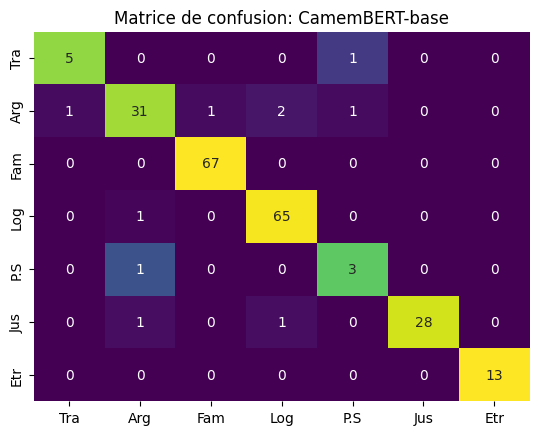

In [35]:
# Afficher la matrice de confusion
# Remplacez ces noms par vos vrais noms de catégories
category_names = ['Tra', 'Arg', 'Fam', 'Log', 'P.S', 'Jus', 'Etr']

plot_confusion_matrix(labels, camembert_preds, category_names)
